# Traffic Jam Problem

In [289]:
from IPython.display import Image
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)}) #Set our seaborn aesthetics (we're going to customize our figure size)

import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from sklearn import metrics

# Problem

This challenge asks you to **build a model that predicts the number of seats that Mobiticket can expect to sell for each ride, i.e. for a specific route on a specific date and time.** There are 14 routes in this dataset. All of the routes end in Nairobi and originate in towns to the North-West of Nairobi towards Lake Victoria.

The routes from these 14 origins to the first stop in the outskirts of Nairobi takes approximately 8 to 9 hours from time of departure. From the first stop in the outskirts of Nairobi into the main bus terminal, where most passengers get off, in Central Business District, takes another 2 to 3 hours depending on traffic.

The three stops that all these routes make in Nairobi (in order) are:

1. Kawangware: the first stop in the outskirts of Nairobi
2. Westlands
3. Afya Centre: the main bus terminal where most passengers disembark

All of these points are mapped here.

Passengers of these bus (or shuttle) rides are affected by Nairobi traffic not only during their ride into the city, but from there they must continue their journey to their final destination in Nairobi wherever that may be. Traffic can act as a deterrent for those who have the option to avoid buses that arrive in Nairobi during peak traffic hours. On the other hand, traffic may be an indication for people’s movement patterns, reflecting business hours, cultural events, political events, and holidays.



# Data Cleaning

## Making Useable Data Frame

In [396]:
train = pd.read_csv("train_revised.csv")
train.head()
# The data does not have explicit information on the number of seats sold for each ride

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [397]:
train.columns.tolist()

['ride_id',
 'seat_number',
 'payment_method',
 'payment_receipt',
 'travel_date',
 'travel_time',
 'travel_from',
 'travel_to',
 'car_type',
 'max_capacity']

In [231]:
# Dropping travel_from == Kendu Bay and Keumbu to match test data | 
train = train[train.travel_from != 'Kendu Bay'] 
train = train[train.travel_from != 'Keumbu']

In [232]:
train.shape

(51622, 10)

In [233]:
# Each row is one ticket and ride_id is one individual ride
len(train['ride_id'].unique())

6228

In [234]:
train.query("ride_id == 5777")
# The attributes for each ride_id is the same (except for seat_number and payment_receipt)

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
5,5777,18B,Mpesa,B6PBDU30IZ,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
6,5777,14A,Mpesa,MZHGDGS6QZ,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
60,5777,15B,Mpesa,7C7P3D5AJQ,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
62,5777,16B,Mpesa,P013NWHQID,27-11-17,7:10,Homa Bay,Nairobi,Bus,49


In [235]:
train['number_of_seats'] = np.linspace(1,1,51622)
train.head()
# Adding col for each seat sold

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_seats
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49,1.0
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49,1.0
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49,1.0
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49,1.0
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49,1.0


In [236]:
# Number of tickets sold per ride
nos_data = train.groupby('ride_id').sum()[['number_of_seats']]
nos_data.head()

,number_of_seats
ride_id,
1442,1.0
5437,1.0
5710,1.0
5777,5.0
5778,31.0


In [237]:
# Dropping duplicate ride_id rows (row count is the same as nos_data)
train_drop_dup = train.drop_duplicates(subset='ride_id', keep='first')
train_drop_dup.shape

(6228, 11)

In [238]:
train_proc = pd.merge(train_drop_dup, nos_data, on = 'ride_id')
train_proc = train_proc.drop('seat_number', axis = 1) # dropped to avoid identifying variables
train_proc = train_proc.drop('payment_receipt', axis = 1).set_index('ride_id') # ^
train_proc = train_proc.drop('number_of_seats_x', axis = 1)
train_proc.head()

,payment_method,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_seats_y
ride_id,,,,,,,,
1442,Mpesa,17-10-17,7:15,Migori,Nairobi,Bus,49,1.0
5437,Mpesa,19-11-17,7:12,Migori,Nairobi,Bus,49,1.0
5710,Mpesa,26-11-17,7:05,Keroka,Nairobi,Bus,49,1.0
5777,Mpesa,27-11-17,7:10,Homa Bay,Nairobi,Bus,49,5.0
5778,Mpesa,27-11-17,7:12,Migori,Nairobi,Bus,49,31.0


In [239]:
train_proc.shape
# The same number of rows

(6228, 8)

## Transforming Data (EDA)

I am only transforming this set for exploratory analysis right now

In [240]:
from datetime import datetime, date

In [241]:
date_form = pd.to_datetime(train_proc.travel_date, infer_datetime_format=True)

In [242]:
# Spliting up travel date
train_proc['travel_date'] = date_form
train_proc['month'] = train_proc['travel_date'].dt.month
train_proc['year'] = train_proc['travel_date'].dt.year
train_proc['day'] = train_proc['travel_date'].dt.day
train_proc.head()

,payment_method,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_seats_y,month,year,day
ride_id,,,,,,,,,,,
1442,Mpesa,2017-10-17,7:15,Migori,Nairobi,Bus,49,1.0,10,2017,17
5437,Mpesa,2017-11-19,7:12,Migori,Nairobi,Bus,49,1.0,11,2017,19
5710,Mpesa,2017-11-26,7:05,Keroka,Nairobi,Bus,49,1.0,11,2017,26
5777,Mpesa,2017-11-27,7:10,Homa Bay,Nairobi,Bus,49,5.0,11,2017,27
5778,Mpesa,2017-11-27,7:12,Migori,Nairobi,Bus,49,31.0,11,2017,27


In [243]:
# Formatting travel_time
train_proc['td_minutes'] = pd.to_datetime(train_proc.travel_time, infer_datetime_format=True).dt.minute
train_proc['td_hour'] = pd.to_datetime(train_proc.travel_time, infer_datetime_format=True).dt.hour
train_proc.head()

,payment_method,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_seats_y,month,year,day,td_minutes,td_hour
ride_id,,,,,,,,,,,,,
1442,Mpesa,2017-10-17,7:15,Migori,Nairobi,Bus,49,1.0,10,2017,17,15,7
5437,Mpesa,2017-11-19,7:12,Migori,Nairobi,Bus,49,1.0,11,2017,19,12,7
5710,Mpesa,2017-11-26,7:05,Keroka,Nairobi,Bus,49,1.0,11,2017,26,5,7
5777,Mpesa,2017-11-27,7:10,Homa Bay,Nairobi,Bus,49,5.0,11,2017,27,10,7
5778,Mpesa,2017-11-27,7:12,Migori,Nairobi,Bus,49,31.0,11,2017,27,12,7


In [244]:
# Formatting travel_time (=departure time), format="%H:%M"
#train_proc["travel_time"] = pd.to_datetime(train_proc.travel_time, format="%H:%M").dt.time
#train_proc.head()

In [245]:
train_proc["weekday_num"] = train_proc["travel_date"].apply(lambda x: x.weekday())
train_proc["weekday"] = train_proc["weekday_num"].replace({0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"})
train_proc.head()

,payment_method,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_seats_y,month,year,day,td_minutes,td_hour,weekday_num,weekday
ride_id,,,,,,,,,,,,,,,
1442,Mpesa,2017-10-17,7:15,Migori,Nairobi,Bus,49,1.0,10,2017,17,15,7,1,Tues
5437,Mpesa,2017-11-19,7:12,Migori,Nairobi,Bus,49,1.0,11,2017,19,12,7,6,Sun
5710,Mpesa,2017-11-26,7:05,Keroka,Nairobi,Bus,49,1.0,11,2017,26,5,7,6,Sun
5777,Mpesa,2017-11-27,7:10,Homa Bay,Nairobi,Bus,49,5.0,11,2017,27,10,7,0,Mon
5778,Mpesa,2017-11-27,7:12,Migori,Nairobi,Bus,49,31.0,11,2017,27,12,7,0,Mon


In [246]:
train_eda = train_proc.drop('weekday_num', axis = 1)
train_eda.head()

,payment_method,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_seats_y,month,year,day,td_minutes,td_hour,weekday
ride_id,,,,,,,,,,,,,,
1442,Mpesa,2017-10-17,7:15,Migori,Nairobi,Bus,49,1.0,10,2017,17,15,7,Tues
5437,Mpesa,2017-11-19,7:12,Migori,Nairobi,Bus,49,1.0,11,2017,19,12,7,Sun
5710,Mpesa,2017-11-26,7:05,Keroka,Nairobi,Bus,49,1.0,11,2017,26,5,7,Sun
5777,Mpesa,2017-11-27,7:10,Homa Bay,Nairobi,Bus,49,5.0,11,2017,27,10,7,Mon
5778,Mpesa,2017-11-27,7:12,Migori,Nairobi,Bus,49,31.0,11,2017,27,12,7,Mon


In [144]:
train_eda.to_csv("train_eda")

# EDA

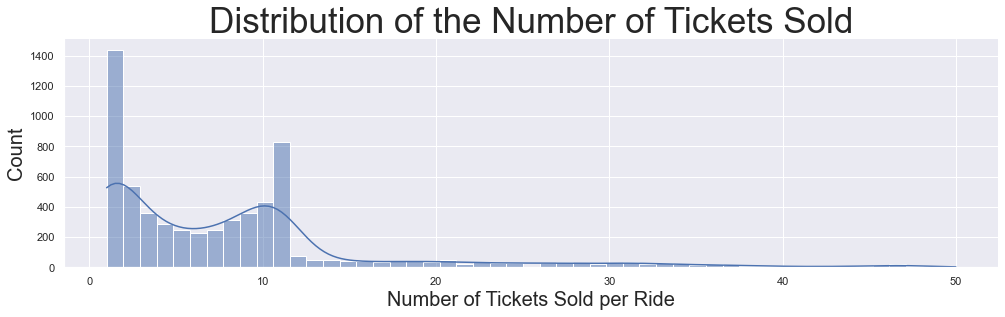

In [145]:
sns.displot(train_eda, x='number_of_seats_y', kde = True, aspect = 3.5, height = 4)
plt.title("Distribution of the Number of Tickets Sold", size = 35)
plt.xlabel("Number of Tickets Sold per Ride", size = 20)
plt.ylabel("Count", size = 20);

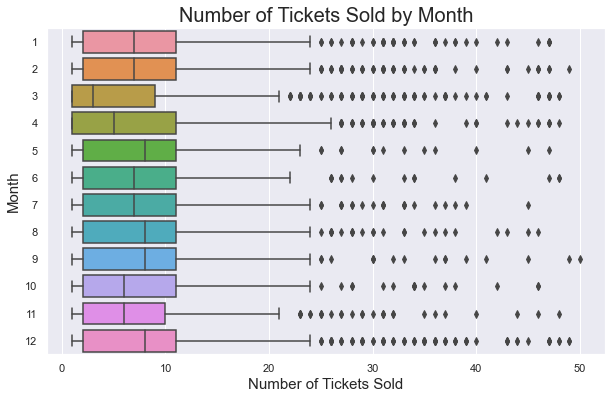

In [146]:
sns.boxplot(data = train_eda, y = 'month', x = 'number_of_seats_y', orient = 'h')
plt.title("Number of Tickets Sold by Month", size = 20)
plt.xlabel("Number of Tickets Sold", size = 15)
plt.ylabel("Month", size = 15);
# Would like to reorder how the boxes are shown

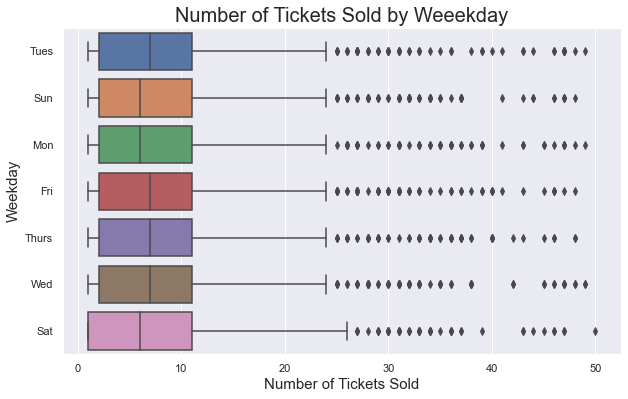

In [147]:
sns.boxplot(data = train_eda, y = 'weekday', x = 'number_of_seats_y', orient = 'h')
plt.title("Number of Tickets Sold by Weeekday", size = 20)
plt.xlabel("Number of Tickets Sold", size = 15)
plt.ylabel("Weekday", size = 15);

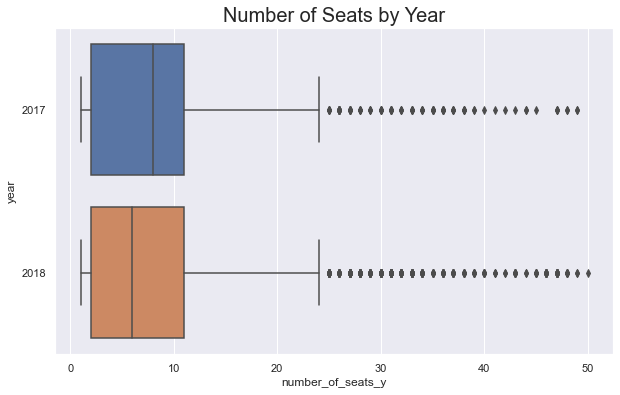

In [148]:
sns.boxplot(data = train_eda, y = 'year', x = 'number_of_seats_y', orient = 'h')
plt.title("Number of Seats by Year", size = 20);

In [149]:
#sns.boxplot(data = copy_df, y = 'time_of_day', x = 'number_of_seats_y')
#plt.title("Number of Seats by Time of Day", size = 20);

In [228]:
#sns.relplot(data = train_eda, y = 'number_of_seats_y', x = 'td_hour', kind = 'line', aspect = 3.5)
#plt.title("Number of Seats by Hour of Travel (hours)", size = 30);
#Maybe good to make time into categorical ranges and do a boxplot 

In [229]:
#sns.relplot(data = train_eda, y = 'number_of_seats_y', x = 'td_hour', kind = 'scatter', aspect = 3.5)
#plt.title("Number of Seats by Hour of Travel (hours)", size = 20);
#Maybe good to make time into categorical ranges and do a boxplot 

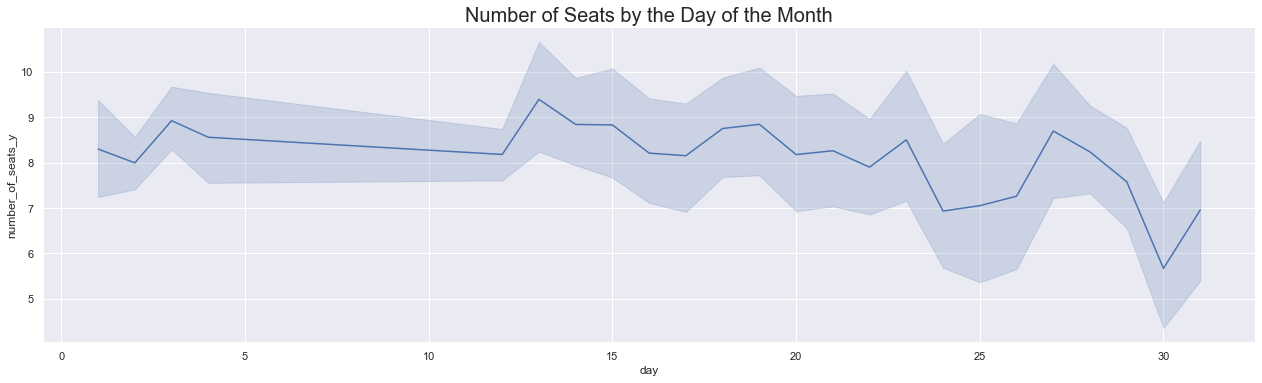

In [153]:
sns.relplot(data = train_eda, y = 'number_of_seats_y', x = 'day', kind = 'line', aspect = 3.5)
plt.title("Number of Seats by the Day of the Month", size = 20);

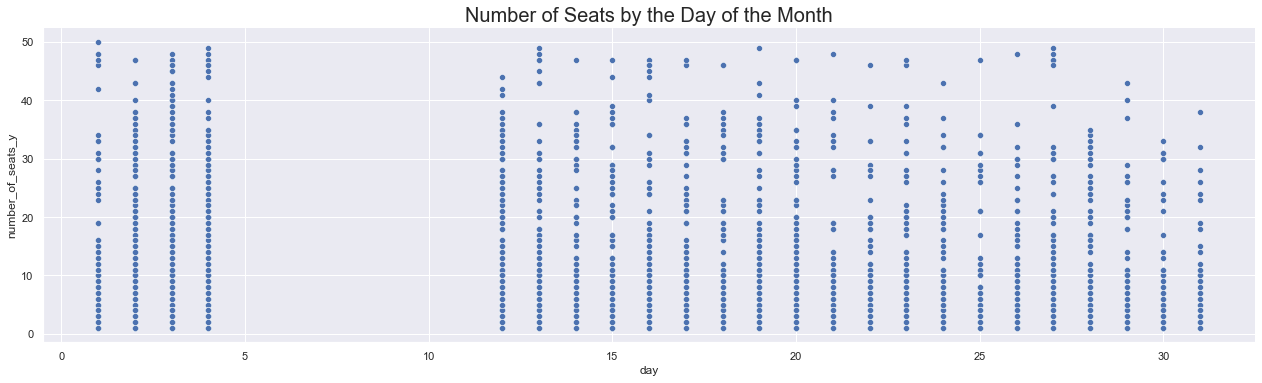

In [154]:
sns.relplot(data = train_eda, y = 'number_of_seats_y', x = 'day', kind = 'scatter', aspect = 3.5)
plt.title("Number of Seats by the Day of the Month", size = 20);
#Interesting that there's no data for days 4 to 12

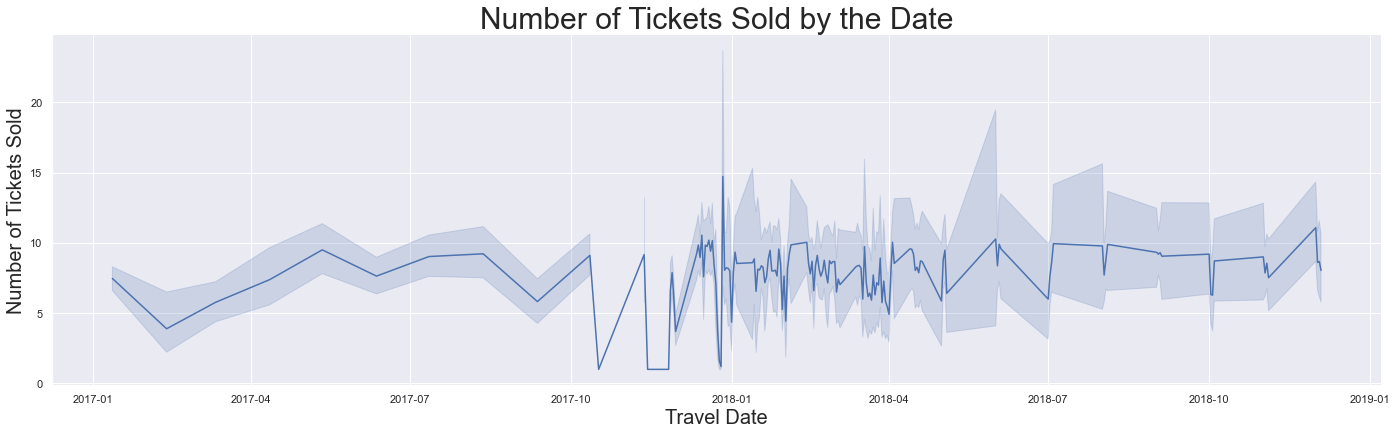

In [66]:
sns.relplot(data = train_eda, y = 'number_of_seats_y', x = 'travel_date', kind = 'line', height=5.5, aspect=3.5)
plt.title("Number of Tickets Sold by the Date", size = 30)
plt.xlabel("Travel Date", size = 20)
plt.ylabel("Number of Tickets Sold", size = 20);

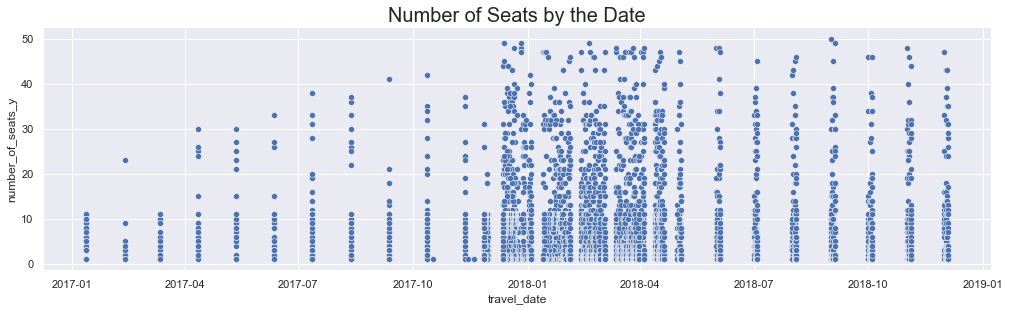

In [27]:
sns.relplot(data = train_eda, y = 'number_of_seats_y', x = 'travel_date', kind = 'scatter', height=4, aspect=3.5)
plt.title("Number of Seats by the Date", size = 20);

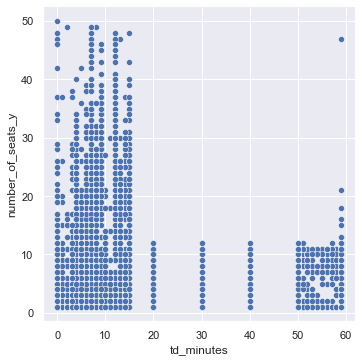

In [126]:
sns.relplot(data = copy_df, x = 'td_minutes', y = 'number_of_seats_y')
plt.title("Number of Seats vs. Minutes out of the Hour");

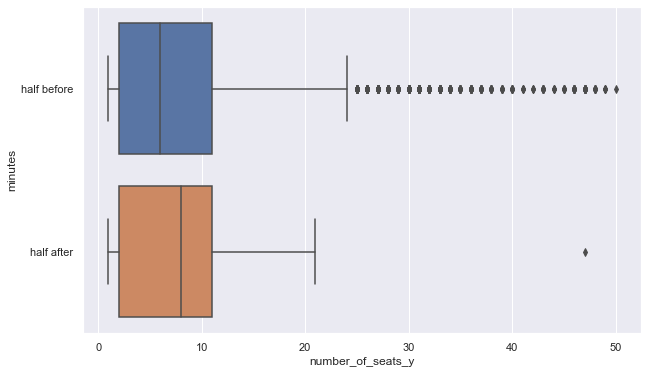

In [161]:
#sns.boxplot(data = train_proc, y = 'minutes', x = 'number_of_seats_y');

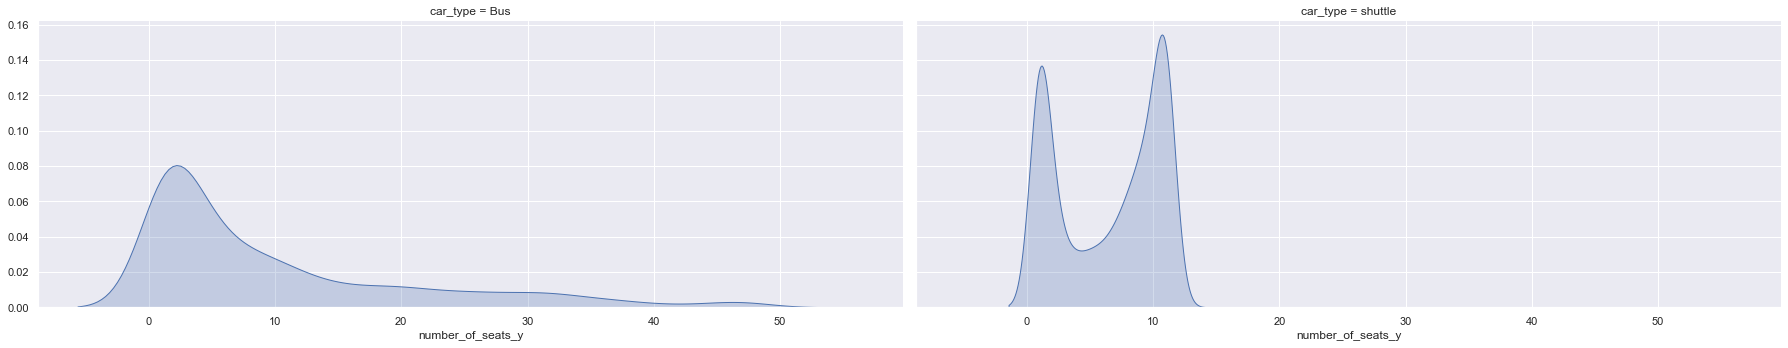

In [70]:
fg = sns.FacetGrid(data = train_eda, col = 'car_type', size=5, aspect=2.5, height = 5)
fg.map(sns.kdeplot, "number_of_seats_y", shade=True);
#plt.xlabel("Number of Tickets Sold", size = 20);

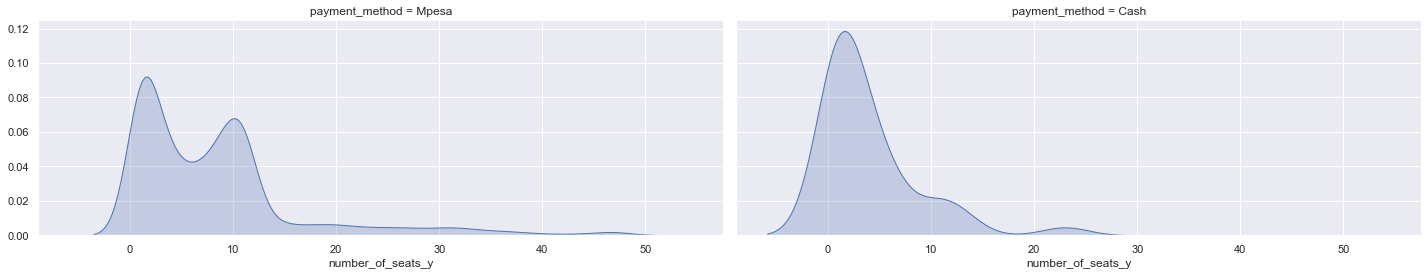

In [29]:
fg = sns.FacetGrid(data = train_eda, col = 'payment_method', size=4, aspect=2.5,)
fg.map(sns.kdeplot, "number_of_seats_y", shade=True);

In [30]:
train_eda.groupby('travel_from')[['number_of_seats_y']].agg(['min', 'mean', 'median', 'max'])

number_of_seats_y                        
                          min       mean median   max
travel_from                                          
Awendo                    1.0   9.664865    6.0  36.0
Homa Bay                  1.0  17.707865   18.5  46.0
Kehancha                  1.0  11.098837   11.0  30.0
Keroka                    1.0   3.166667    1.0  12.0
Kijauri                   1.0   1.854317    1.0  11.0
Kisii                     1.0   7.485762    8.0  49.0
Mbita                     2.0  18.000000   13.0  37.0
Migori                    1.0  18.204663   17.0  49.0
Ndhiwa                    1.0  10.727273   11.0  13.0
Nyachenge                 1.0   2.612245    2.0  11.0
Oyugis                    1.0   2.500000    2.5   4.0
Rodi                      1.0   7.941176    8.0  14.0
Rongo                     1.0   5.322493    3.0  37.0
Sirare                    1.0  23.293194   21.0  50.0
Sori                      1.0   2.750000    2.0  10.0

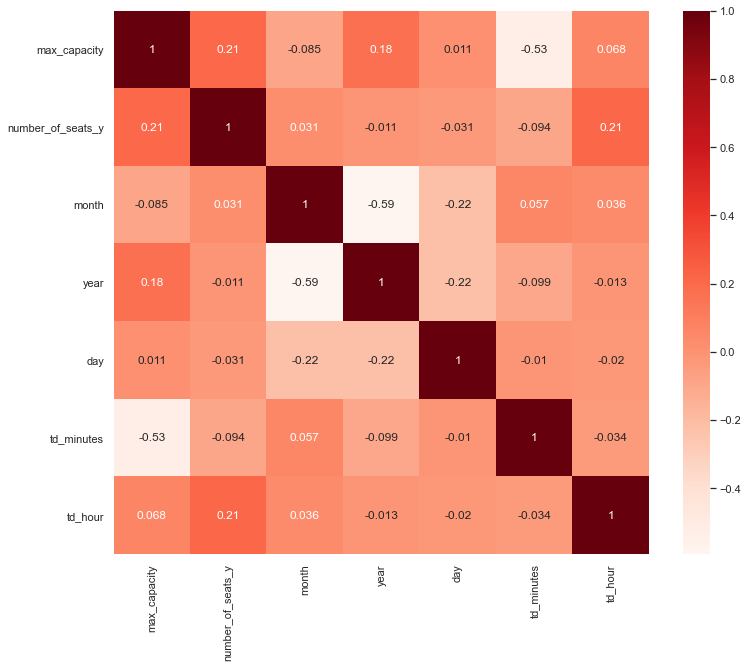

In [31]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = train_eda.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Transforming Data (ML)

Trying to separate target and feature columns before transforming

In [247]:
train_ml = train_eda.drop('travel_date', axis = 1).drop('year', axis = 1).drop('travel_to', axis = 1).drop('payment_method', axis = 1).drop('max_capacity', axis = 1).drop('travel_time', axis = 1)
train_ml.head()
# dropped the columns to match the test set. I also wanted to make month categorical, but there are more months in the training set than the test set so I couldn't get it to work

,travel_from,car_type,number_of_seats_y,month,day,td_minutes,td_hour,weekday
ride_id,,,,,,,,
1442,Migori,Bus,1.0,10,17,15,7,Tues
5437,Migori,Bus,1.0,11,19,12,7,Sun
5710,Keroka,Bus,1.0,11,26,5,7,Sun
5777,Homa Bay,Bus,5.0,11,27,10,7,Mon
5778,Migori,Bus,31.0,11,27,12,7,Mon


In [220]:
#train_ml['month'] = pd.Categorical(train_ml['month'])
#train_ml['max_capacity'] = pd.Categorical(train_ml['max_capacity'])

In [248]:
train_ml = pd.get_dummies(train_ml,prefix=['travel_from'], columns = ['travel_from'], drop_first=True)
train_ml = pd.get_dummies(train_ml,prefix=['car_type'], columns = ['car_type'], drop_first=True)
#train_ml = pd.get_dummies(train_ml,prefix=['travel_time'], columns = ['travel_time'], drop_first=True)
train_ml = pd.get_dummies(train_ml,prefix=['weekday'], columns = ['weekday'], drop_first=True)

In [249]:
train_ml.head()

,number_of_seats_y,month,day,td_minutes,td_hour,travel_from_Homa Bay,travel_from_Kehancha,travel_from_Keroka,travel_from_Kijauri,travel_from_Kisii,...,travel_from_Rongo,travel_from_Sirare,travel_from_Sori,car_type_shuttle,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed
ride_id,,,,,,,,,,,,,,,,,,,,,
1442,1.0,10,17,15,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5437,1.0,11,19,12,7,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5710,1.0,11,26,5,7,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5777,5.0,11,27,10,7,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5778,31.0,11,27,12,7,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Training Data (Random Linear Regression)

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [381]:
measures = {}

In [360]:
target = "number_of_seats_y"
feature_cols = train_ml.drop("number_of_seats_y", axis = 1).columns

In [361]:
train_cols = feature_cols.tolist()

In [362]:
X = train_ml[feature_cols]
y = train_ml[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [363]:
model = LinearRegression()
model.fit(X = X_train, y = y_train)

LinearRegression()

In [364]:
predictions = model.predict(X_test)
for y, y_pred in list(zip(y_test, predictions))[:5]:
    print("Real value: {:.3f} Estimated value: {:.5f}".format(y, y_pred))

Real value: 3.000 Estimated value: 9.90826
Real value: 10.000 Estimated value: 6.01134
Real value: 7.000 Estimated value: 5.87219
Real value: 9.000 Estimated value: 8.52445
Real value: 7.000 Estimated value: 6.21992


In [365]:
X = X_test.reset_index().copy() # make a copy of indices and data
X["target"] = y_test.tolist()
X["prediction"] = predictions
X.head()

,ride_id,month,day,td_minutes,td_hour,travel_from_Homa Bay,travel_from_Kehancha,travel_from_Keroka,travel_from_Kijauri,travel_from_Kisii,...,travel_from_Sori,car_type_shuttle,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,target,prediction
0,13695,4,18,12,7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.0,9.908264
1,7486,2,24,10,6,0,0,0,0,1,...,0,1,0,1,0,0,0,0,10.0,6.011343
2,11239,12,15,40,5,0,0,0,0,1,...,0,1,0,0,0,0,0,0,7.0,5.872185
3,8430,9,2,0,8,0,0,0,0,1,...,0,1,0,0,1,0,0,0,9.0,8.524447
4,10492,12,24,50,7,0,0,0,0,1,...,0,1,0,0,1,0,0,0,7.0,6.219919


In [366]:
X.shape

(1246, 28)

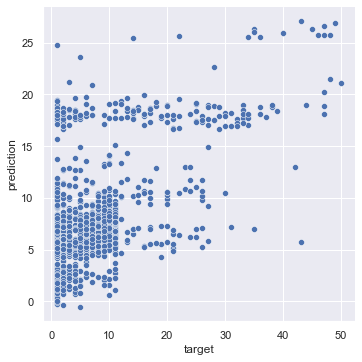

In [367]:
sns.relplot(x="target", y="prediction", data=X, kind="scatter");

# Cross-Validation

In [368]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import SCORERS

In [369]:
#SCORERS.keys()

In [370]:
results_cross_validation = cross_val_score(
    estimator=model, 
    X=train_ml[feature_cols],
    y=train_ml[target],
    scoring="neg_mean_absolute_error", 
    cv=6,
)

In [371]:
def rmse_cross_val(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

In [372]:
from sklearn.model_selection import cross_validate

scoring_functions = {"mae": "neg_mean_absolute_error", "r_sqd": "r2", "mse": 'neg_mean_squared_error'}

scores = cross_validate(
    model,                # estimator
    X=train_ml[feature_cols],
    y=train_ml[target],          
    scoring=scoring_functions, # a single scorer or a dict with multiple scoring functions
    cv=20,                      # number of partitions
    return_train_score=True,
    return_estimator = True # return the training error, not only the test error
)

In [373]:
results = pd.DataFrame(scores)
results

,fit_time,score_time,estimator,test_mae,train_mae,test_r_sqd,train_r_sqd,test_mse,train_mse
0,0.008529,0.002944,LinearRegression(),-5.657456,-4.682619,-1.947121,0.384958,-41.370016,-46.813989
1,0.005775,0.002474,LinearRegression(),-4.017670,-4.766611,0.083518,0.383083,-29.454626,-47.382532
2,0.005062,0.002378,LinearRegression(),-4.144549,-4.757657,0.312270,0.379992,-37.074175,-46.923220
3,0.006715,0.002309,LinearRegression(),-3.912149,-4.777832,0.384468,0.377300,-34.869469,-47.037802
4,0.004862,0.002687,LinearRegression(),-3.946188,-4.776274,0.414602,0.376186,-32.904845,-47.136676
5,0.004477,0.001945,LinearRegression(),-4.968346,-4.730086,0.382051,0.376867,-54.772850,-46.011508
6,0.004526,0.001970,LinearRegression(),-4.713794,-4.732691,0.435641,0.372509,-50.867970,-46.258572
7,0.004442,0.001902,LinearRegression(),-4.698134,-4.739468,0.302602,0.380702,-44.661277,-46.532382
8,0.004409,0.001913,LinearRegression(),-4.333162,-4.761934,0.233961,0.382144,-37.054708,-46.931332
9,0.004301,0.001843,LinearRegression(),-4.281230,-4.767899,0.423833,0.375128,-36.828514,-46.937649


In [374]:
model2 = results.estimator[4]
model2
# This was the model used to test the test data

LinearRegression()

In [375]:
y_pred = model2.predict(X_test)

In [376]:
# Model Evaluation
acc_rf_train = metrics.r2_score(y_test, y_pred)
print('R^2:',metrics.r2_score(y_test, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.37412428256008534
Adjusted R^2: 0.36129896048139853
MAE: 4.634406864246275
MSE: 44.873242539427736
RMSE: 6.698749326510713


In [377]:
cross_validation = {'R^2': metrics.r2_score(y_test, y_pred), 
                    'Adjusted R^2': 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),
                    'MAE': metrics.mean_absolute_error(y_test, y_pred),
                   'MSE': metrics.mean_squared_error(y_test, y_pred),
                   'RMSE': np.sqrt(metrics.mean_squared_error(y_test, y_pred))}

In [379]:
cross_validation

{'R^2': 0.37412428256008534,
 'Adjusted R^2': 0.36129896048139853,
 'MAE': 4.634406864246275,
 'MSE': 44.873242539427736,
 'RMSE': 6.698749326510713}

In [382]:
measures['Linear Regression'] = cross_validation

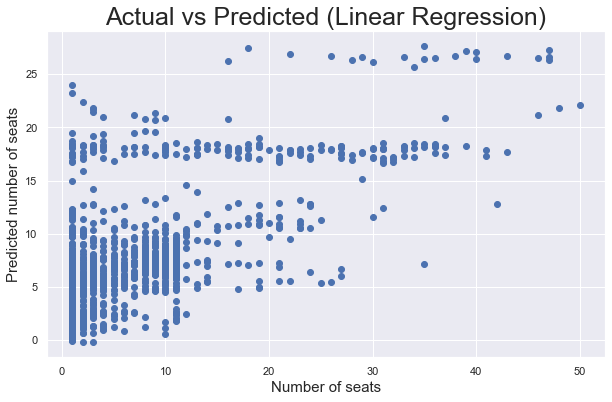

In [357]:
plt.scatter(y_test, y_pred)
plt.xlabel("Number of seats", size = 15)
plt.ylabel("Predicted number of seats", size = 15)
plt.title("Actual vs Predicted (Linear Regression)", size = 25)
plt.show()

# XGBResgressor

In [383]:
from xgboost import XGBRegressor

xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [384]:
model3 = xgb.fit(X_train, y_train)

[15:55:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:55:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [385]:
y_pred = model3.predict(X_test)

In [386]:
# Model Evaluation
acc_rf_train = metrics.r2_score(y_test, y_pred)
print('R^2:',metrics.r2_score(y_test, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.5504494164595113
Adjusted R^2: 0.54123731433778
MAE: 3.91650483092326
MSE: 32.23130696213701
RMSE: 5.677262277025521


In [387]:
xgbr = {'R^2': metrics.r2_score(y_test, y_pred), 
                    'Adjusted R^2': 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),
                    'MAE': metrics.mean_absolute_error(y_test, y_pred),
                   'MSE': metrics.mean_squared_error(y_test, y_pred),
                   'RMSE': np.sqrt(metrics.mean_squared_error(y_test, y_pred))}
measures['XGBResgressor'] = xgbr

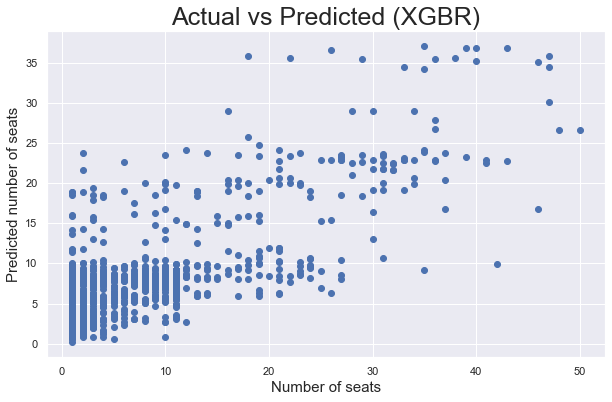

In [347]:
plt.scatter(y_test, y_pred)
plt.xlabel("Number of seats", size = 15)
plt.ylabel("Predicted number of seats", size = 15)
plt.title("Actual vs Predicted (XGBR)", size = 25)
plt.show()

# Random Forest Regressor

In [388]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [389]:
model4 = rfr.fit(X_train, y_train)
y_pred = model4.predict(X_test)

In [390]:
# Model Evaluation
acc_rf_train = metrics.r2_score(y_test, y_pred)
print('R^2:',metrics.r2_score(y_test, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2: 0.6504223775612454
Adjusted R^2: 0.6432589016915988
MAE: 3.198775605747917
MSE: 25.063572528769157
RMSE: 5.006353216540874


In [391]:
rfrm = {'R^2': metrics.r2_score(y_test, y_pred), 
                    'Adjusted R^2': 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),
                    'MAE': metrics.mean_absolute_error(y_test, y_pred),
                   'MSE': metrics.mean_squared_error(y_test, y_pred),
                   'RMSE': np.sqrt(metrics.mean_squared_error(y_test, y_pred))}
measures['Random Forest Regressor'] = rfrm

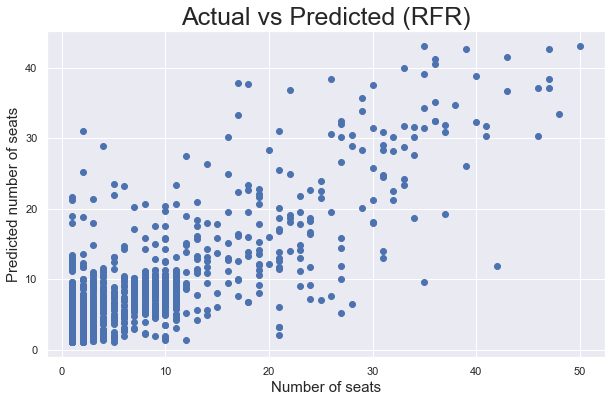

In [341]:
plt.scatter(y_test, y_pred)
plt.xlabel("Number of seats", size = 15)
plt.ylabel("Predicted number of seats", size = 15)
plt.title("Actual vs Predicted (RFR)", size = 25)
plt.show()

# Model Comparisons

In [392]:
measures

{'Linear Regression': {'R^2': 0.37412428256008534,
  'Adjusted R^2': 0.36129896048139853,
  'MAE': 4.634406864246275,
  'MSE': 44.873242539427736,
  'RMSE': 6.698749326510713},
 'XGBResgressor': {'R^2': 0.5504494164595113,
  'Adjusted R^2': 0.54123731433778,
  'MAE': 3.91650483092326,
  'MSE': 32.23130696213701,
  'RMSE': 5.677262277025521},
 'Random Forest Regressor': {'R^2': 0.6504223775612454,
  'Adjusted R^2': 0.6432589016915988,
  'MAE': 3.198775605747917,
  'MSE': 25.063572528769157,
  'RMSE': 5.006353216540874}}

In [395]:
pd.DataFrame.from_dict(measures).T

,R^2,Adjusted R^2,MAE,MSE,RMSE
Linear Regression,0.374124,0.361299,4.634407,44.873243,6.698749
XGBResgressor,0.550449,0.541237,3.916505,32.231307,5.677262
Random Forest Regressor,0.650422,0.643259,3.198776,25.063573,5.006353


# Test

In [319]:
test_csv = pd.read_csv("test_questions.csv", index_col = 'ride_id')
test_csv.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
ride_id,,,,,,
247,2018-05-07,07:06,Kisii,Nairobi,Bus,49
256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11
275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11
285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11
286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11


In [320]:
 date_form_test = pd.to_datetime(test_csv.travel_date, infer_datetime_format=True)

In [321]:
# Spliting up travel date
test_csv['travel_date'] = date_form_test
test_csv['month'] = test_csv['travel_date'].dt.month
test_csv['year'] = test_csv['travel_date'].dt.year
test_csv['day'] = test_csv['travel_date'].dt.day
test_csv.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,month,year,day
ride_id,,,,,,,,,
247,2018-05-07,07:06,Kisii,Nairobi,Bus,49,5,2018,7
256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11,5,2018,6
275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11,5,2018,4
285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11,5,2018,4
286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11,5,2018,4


In [322]:
# Formatting travel_time
test_csv['td_minutes'] = pd.to_datetime(test_csv.travel_time, infer_datetime_format=True).dt.minute
test_csv['td_hour'] = pd.to_datetime(test_csv.travel_time, infer_datetime_format=True).dt.hour
test_csv.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,month,year,day,td_minutes,td_hour
ride_id,,,,,,,,,,,
247,2018-05-07,07:06,Kisii,Nairobi,Bus,49,5,2018,7,6,7
256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11,5,2018,6,8,11
275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11,5,2018,4,0,5
285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11,5,2018,4,10,9
286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11,5,2018,4,20,9


In [323]:
# Formatting travel_time (=departure time), format="%H:%M"
#test_csv["travel_time"] = pd.to_datetime(test_csv.travel_time, format="%H:%M").dt.time
#test_csv.head()

In [324]:
test_csv["weekday_num"] = test_csv["travel_date"].apply(lambda x: x.weekday())
test_csv["weekday"] = test_csv["weekday_num"].replace({0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"})
test_csv.head()

,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,month,year,day,td_minutes,td_hour,weekday_num,weekday
ride_id,,,,,,,,,,,,,
247,2018-05-07,07:06,Kisii,Nairobi,Bus,49,5,2018,7,6,7,0,Mon
256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11,5,2018,6,8,11,6,Sun
275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11,5,2018,4,0,5,4,Fri
285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11,5,2018,4,10,9,4,Fri
286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11,5,2018,4,20,9,4,Fri


In [325]:
test_csv = test_csv.drop('travel_date', axis = 1).drop('max_capacity', axis = 1).drop('travel_to', axis = 1).drop('year', axis = 1).drop('weekday_num', axis = 1).drop('travel_time', axis = 1)
test_csv.head()

,travel_from,car_type,month,day,td_minutes,td_hour,weekday
ride_id,,,,,,,
247,Kisii,Bus,5,7,6,7,Mon
256,Kisii,shuttle,5,6,8,11,Sun
275,Kisii,shuttle,5,4,0,5,Fri
285,Kisii,shuttle,5,4,10,9,Fri
286,Kisii,shuttle,5,4,20,9,Fri


In [326]:
test_csv.dtypes

travel_from    object
car_type       object
month           int64
day             int64
td_minutes      int64
td_hour         int64
weekday        object
dtype: object

In [327]:
test_csv = pd.get_dummies(test_csv,prefix=['travel_from'], columns = ['travel_from'], drop_first=True)
test_csv = pd.get_dummies(test_csv,prefix=['car_type'], columns = ['car_type'], drop_first=True)
test_csv = pd.get_dummies(test_csv,prefix=['weekday'], columns = ['weekday'], drop_first=True)
#test_csv = pd.get_dummies(test_csv,prefix=['travel_time'], columns = ['travel_time'], drop_first=True)

In [328]:
test_csv.head()

,month,day,td_minutes,td_hour,travel_from_Homa Bay,travel_from_Kehancha,travel_from_Keroka,travel_from_Kijauri,travel_from_Kisii,travel_from_Mbita,...,travel_from_Rongo,travel_from_Sirare,travel_from_Sori,car_type_shuttle,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed
ride_id,,,,,,,,,,,,,,,,,,,,,
247,5,7,6,7,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
256,5,6,8,11,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
275,5,4,0,5,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
285,5,4,10,9,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
286,5,4,20,9,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [329]:
test_csv.shape

(1111, 25)

In [398]:
test_columns = test_csv.columns.tolist()

In [399]:
list(set(test_columns).symmetric_difference(set(train_cols))) # There is one different travel_time value in the test_csv

[]

In [332]:
predictions_test = model4.predict(test_csv)

In [333]:
predictions_test

array([ 2.26,  2.92,  1.65, ...,  6.58, 10.68, 20.53])

In [334]:
test = test_csv.copy()
test['number_of_ticket'] = np.round(predictions_test,0)
test.head()

,month,day,td_minutes,td_hour,travel_from_Homa Bay,travel_from_Kehancha,travel_from_Keroka,travel_from_Kijauri,travel_from_Kisii,travel_from_Mbita,...,travel_from_Sirare,travel_from_Sori,car_type_shuttle,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,number_of_ticket
ride_id,,,,,,,,,,,,,,,,,,,,,
247,5,7,6,7,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,2.0
256,5,6,8,11,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,3.0
275,5,4,0,5,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,2.0
285,5,4,10,9,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,5.0
286,5,4,20,9,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,5.0


In [335]:
test[['number_of_ticket']]

,number_of_ticket
ride_id,
247,2.0
256,3.0
275,2.0
285,5.0
286,5.0
...,...
15336,5.0
15337,10.0
15338,7.0


In [336]:
test[['number_of_ticket']].to_csv("resuts_1")